Инициализация всех модулей

In [1]:
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import re
import matplotlib.pyplot as plt

2024-08-29 02:52:46.639120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 02:52:47.450003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 02:52:47.570458: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 02:52:49.899681: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Для проверки на GPU.
Возвращает [] в случае, если карта не обнаружена. Иначе возвращает список всех доступных карт

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1724896547.423361    1126 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724896547.432548    1126 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724896547.432604    1126 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Загрузка датасета и перевод в формат, пригодный для нейросети

In [335]:

df = pd.read_csv('labeled.csv')

X = df['comment']
y = df['toxic']

maxWordsCount = 10000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!–"—#$%&amp;()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r«»', lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

# Pad the sequences
max_sequence_length = 32
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post')


print(df)



                                                 comment  toxic
0                 Верблюдов-то за что? Дебилы, бл...\r\n    1.0
1      Хохлы, это отдушина затюканого россиянина, мол...    1.0
2                            Собаке - собачья смерть\r\n    1.0
3      Страницу обнови, дебил. Это тоже не оскорблени...    1.0
4      тебя не убедил 6-страничный пдф в том, что Скр...    1.0
...                                                  ...    ...
14407  Вонючий совковый скот прибежал и ноет. А вот и...    1.0
14408  А кого любить? Гоблина тупорылого что-ли? Или ...    1.0
14409  Посмотрел Утомленных солнцем 2. И оказалось, ч...    0.0
14410  КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...    1.0
14411  До сих пор пересматриваю его видео. Орамбо кст...    0.0

[14412 rows x 2 columns]


Конфигурация RNN для поставленной задачи и её обучение

In [339]:

embedding_dim = 256

model = Sequential()
model.add(Embedding(input_dim=maxWordsCount, output_dim=embedding_dim))
model.add(LSTM(128, return_sequences=True))


model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(128, return_sequences=False))



model.add(Dense(1, activation='sigmoid'))  

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_padded, y, epochs=5, batch_size=512, validation_split=0.2)


Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.6552 - loss: 0.6468 - val_accuracy: 0.7385 - val_loss: 0.5117
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7751 - loss: 0.4769 - val_accuracy: 0.8672 - val_loss: 0.3178
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8979 - loss: 0.2694 - val_accuracy: 0.8862 - val_loss: 0.2699
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9316 - loss: 0.1952 - val_accuracy: 0.8710 - val_loss: 0.3018
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9475 - loss: 0.1549 - val_accuracy: 0.8783 - val_loss: 0.3317


Анализ результатов обучения сети

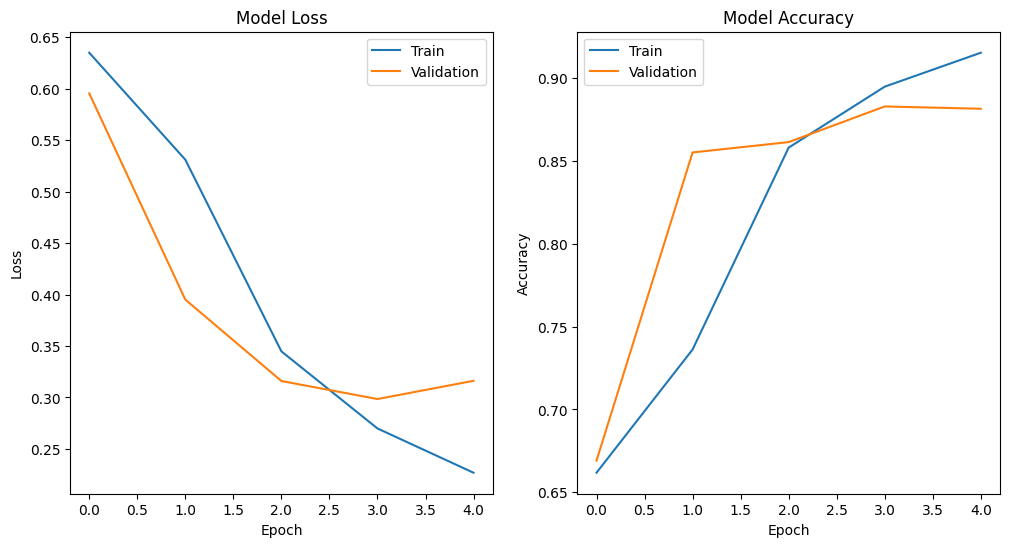

In [318]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()


Пример пользовательского predict

In [350]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np


# idx = 6
# input_string = X[idx]
# print(X[idx],y[idx])
# Tokenize the input string
input_string = input('Введите текст: ')
input_sequence = tokenizer.texts_to_sequences([input_string])

# Pad the sequence
input_padded = pad_sequences(input_sequence, maxlen=max_sequence_length, padding='post')

# Make a prediction
prediction = model.predict(input_padded)

# Display the prediction
print("Prediction (probability of being toxic):", prediction[0][0])

# If you want to convert it to binary (e.g., toxic or not toxic), use a threshold
threshold = 0.91  # Choose a threshold based on your model and problem
binary_prediction = (prediction > threshold).astype(int)
print("Binary Prediction (0: not toxic, 1: toxic):", binary_prediction[0][0])


Введите текст:  sadsa


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction (probability of being toxic): 0.41348627
Binary Prediction (0: not toxic, 1: toxic): 0


Сохранение модели в файл для последующего использования

In [353]:
model.save('analyzer.keras')